<a href="https://colab.research.google.com/github/Ambrissh/JAX_neuralnetwork_scratch/blob/main/NeuralNetworkScratchJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import jax
import jax.numpy as jnp
import time

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder



In [9]:
data=load_iris()
X=data.data
y=data.target.reshape(-1,1)

encoder=OneHotEncoder(sparse_output=False)
y=encoder.fit_transform(y)

print(y)



[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)

(120, 4)
(120, 3)


In [14]:
#neural network
def init__params(input_dim,hidden_layer1,hidden_layer2,output_dim,random_key):
  random_keys=jax.random.split(random_key,3)
  w1=jax.random.normal(random_keys[0],(input_dim,hidden_layer1))
  b1=jnp.zeros((1,hidden_layer1))
  w2=jax.random.normal(random_keys[1],(hidden_layer1,hidden_layer2))
  b2=jnp.zeros((1,hidden_layer2))
  w3=jax.random.normal(random_keys[2],(hidden_layer2,output_dim))
  b3=jnp.zeros((1,output_dim))

  return w1,b1,w2,b2,w3,b3




In [15]:
#defining the forward pass
def forward_pass(params,X):
  w1,b1,w2,b2,w3,b3=params

  h1=jax.nn.relu(jnp.dot(X,w1)+b1)
  h2=jax.nn.relu(jnp.dot(h1,w2)+b2)
  logits=jnp.dot(h2,w3)+b3

  return logits






In [17]:
#defining the loss function
def loss_function(params,X,y,l2reg=0.0001):

  logits=forward_pass(params,X)
  probs=jax.nn.softmax(logits)
  l2_loss=l2reg*(jnp.sum(jnp.square(params[0]))+jnp.sum(jnp.square(params[2]))+jnp.sum(jnp.square(params[4])))
  return -jnp.mean(jnp.sum(y*jnp.log(probs+1e-8),axis=1))+l2_loss #cross entropy loss






In [23]:
#training step

@jax.jit
def training_step(params,x,y,lr):
  grads=jax.grad(loss_function)(params,x,y)
  return [(param-lr*grad) for param,grad in zip(params,grads)]



In [24]:
#accuracy
def accuracy(params,x,y):
  preds=jnp.argmax(forward_pass(params,x),axis=1)
  targets=jnp.argmax(y,axis=1)
  return jnp.mean(preds==targets)



In [31]:
def data_loader(X,y,batch_size):
  for i in range(0,len(X),batch_size):
    yield X[i:i+batch_size],y[i:i+batch_size]

In [27]:
random_key=jax.random.key(int(time.time()))
input_dim=X_train.shape[1]
hidden_layer1=16
hidden_layer2=8
output_dim=y_train.shape[1]
learning_rate=0.005
batch_size=16
epochs=200


In [35]:
params=init__params(input_dim,hidden_layer1,hidden_layer2,output_dim,random_key)
train_accs, test_accs, train_losses, test_losses = [], [], [], []

for epoch in range(epochs):
    for X_batch, y_batch in data_loader(X_train, y_train, batch_size):
        params = training_step(params, X_batch, y_batch, learning_rate)

    # After each epoch, compute metrics
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)
    train_loss = loss_function(params, X_train, y_train)
    test_loss = loss_function(params, X_test, y_test)

    # Store them for plotting later
    train_accs.append(float(train_acc))
    test_accs.append(float(test_acc))
    train_losses.append(float(train_loss))
    test_losses.append(float(test_loss))

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Train Loss: {train_loss:.4f}")


Epoch 000 | Train Acc: 0.5333 | Test Acc: 0.4667 | Train Loss: 5.1869
Epoch 010 | Train Acc: 0.9250 | Test Acc: 0.9333 | Train Loss: 0.4078
Epoch 020 | Train Acc: 0.9167 | Test Acc: 0.9000 | Train Loss: 0.2976
Epoch 030 | Train Acc: 0.9167 | Test Acc: 0.9000 | Train Loss: 0.2345
Epoch 040 | Train Acc: 0.9083 | Test Acc: 0.9000 | Train Loss: 0.1905
Epoch 050 | Train Acc: 0.9417 | Test Acc: 0.9000 | Train Loss: 0.1557
Epoch 060 | Train Acc: 0.9500 | Test Acc: 0.9333 | Train Loss: 0.1309
Epoch 070 | Train Acc: 0.9750 | Test Acc: 0.9333 | Train Loss: 0.1158
Epoch 080 | Train Acc: 0.9750 | Test Acc: 0.9333 | Train Loss: 0.1056
Epoch 090 | Train Acc: 0.9833 | Test Acc: 0.9333 | Train Loss: 0.0975
Epoch 100 | Train Acc: 0.9833 | Test Acc: 0.9333 | Train Loss: 0.0915
Epoch 110 | Train Acc: 0.9917 | Test Acc: 0.9667 | Train Loss: 0.0868
Epoch 120 | Train Acc: 0.9917 | Test Acc: 0.9667 | Train Loss: 0.0828
Epoch 130 | Train Acc: 0.9917 | Test Acc: 0.9667 | Train Loss: 0.0793
Epoch 140 | Train Ac

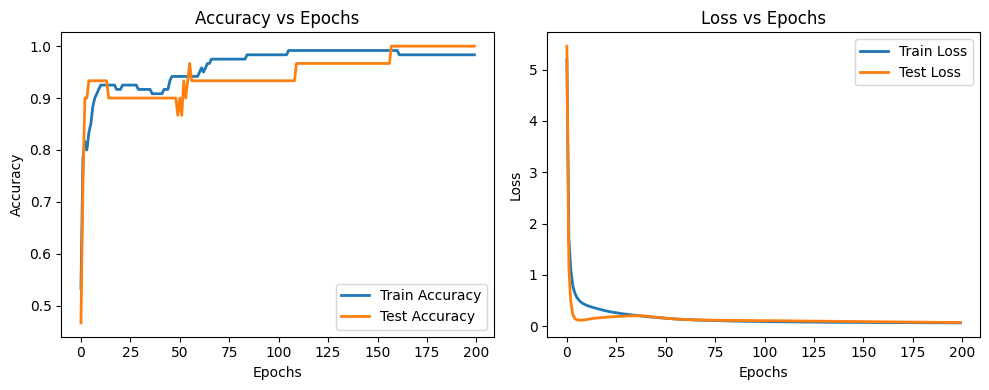

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(test_accs, label='Test Accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
print(f"Final Train Acc: {accuracy(params,X_train,y_train):.4f}")
print(f"Final Test Acc: {accuracy(params,X_test,y_test):.4f}")

Final Train Acc: 0.9833
Final Test Acc: 1.0000
